# Spines Segmentation Inference

### Set Proxy Environment Variables

In [1]:
import os

# Set proxy environment variables
os.environ['http_proxy'] = 'http://proxy:80'
os.environ['https_proxy'] = 'http://proxy:80'

### Import Required Libraries

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random

import torch
from torchvision import models
from albumentations.pytorch import ToTensorV2
import albumentations as A
from PIL import Image
import numpy as np


import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

### Load Inference Model

In [3]:
def get_model_instance_segmentation(num_classes):
    weights = MaskRCNN_ResNet50_FPN_Weights.COCO_V1
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=weights)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 512
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return model

def load_model(model_path, num_classes, device):
    model = get_model_instance_segmentation(num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

### Define Inference Method

In [4]:
def run_inference(model, device, image_path, threshold=0.5):
    transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    
    # Load and preprocess the input image using Albumentations
    img = Image.open(image_path).convert("RGB")
    img = np.array(img)
    transformed = transform(image=img)
    img_tensor = transformed['image']
    img_tensor = img_tensor.unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        prediction = model(img_tensor)

    # Process the predictions
    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()
    pred_masks = prediction[0]['masks'].cpu().numpy()

    # Filter predictions by threshold
    pred_boxes = pred_boxes[pred_scores >= threshold]
    pred_masks = pred_masks[pred_scores >= threshold]
    pred_scores = pred_scores[pred_scores >= threshold]

    return img, pred_boxes, pred_masks, pred_scores

### Visualize Results

In [5]:
def visualize_results(img, boxes, masks, scores, threshold=0.7):
    img_np = np.array(img)

    for i, box in enumerate(boxes):
        if scores[i] >= threshold:
            xmin, ymin, xmax, ymax = box.astype(int)
            # Draw the rectangle
            cv2.rectangle(img_np, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

            # Apply the mask
            mask = masks[i, 0] > 0
            img_np[mask] = [255, 0, 0]  # Red color for mask

    return Image.fromarray(img_np)

def display_results(dset, idx, image_path, predicted_mask):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.title(f'{dset} Image [{idx}]')

    plt.subplot(1, 3, 2)
    image_path = f'Dataset/DeepD3_{dset}/spine_images/spine_{idx}.png'
    mask = Image.open(image_path).convert('L')
    binary_mask = mask.point(lambda p: p > 0 and 255)
    plt.imshow(binary_mask, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title('Spines Mask')
    
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    plt.axis('off')
    plt.title('Predicted Mask')
    plt.show()

### Run Inference

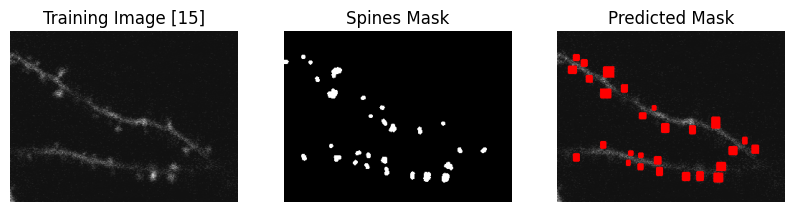

In [7]:
# Set device and number of classes
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # Background and spine

# Load the model
model_path = 'spines_model.pt'
model = load_model(model_path, num_classes, device)

# Perform inference
idx = 15
dset = 'Training'
image_path = f'Dataset/DeepD3_{dset}/input_images/image_{idx}.png'
img, boxes, masks, scores = run_inference(model, device, image_path, threshold=0.5)
predicted_mask = visualize_results(img, boxes, masks, scores, threshold=0.5)

# Display the results
display_results(dset, idx, image_path, predicted_mask)

### Assign Unique Color to Each Spine

In [8]:
# Add unique color to each spine
def visualize_results(img, boxes, masks, scores, threshold=0.5):
    img_np = np.array(img)
    unique_colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(boxes))]
    for i, box in enumerate(boxes):
        if scores[i] >= threshold:
            xmin, ymin, xmax, ymax = box.astype(int)
            # Draw the rectangle
            img_np = cv2.rectangle(img_np, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
            # Apply the mask with a unique color
            mask = masks[i, 0] > 0.5
            color = unique_colors[i]
            img_np[mask] = color
    return Image.fromarray(img_np)

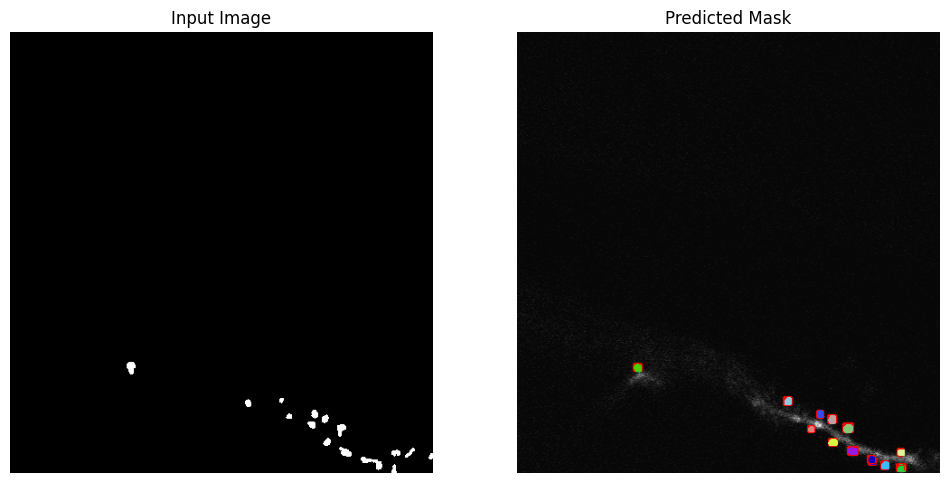

In [88]:
idx = 56
dset = 'Validation'
image_path = f'Dataset/DeepD3_{dset}/input_images/image_{idx}.png'
spine_path = f'Dataset/DeepD3_{dset}/spine_images/spine_{idx}.png'
img, boxes, masks, scores = run_inference(model, device, image_path, threshold=0.5)
predicted_color_mask = visualize_results(img, boxes, masks, scores, threshold=0.5)


plt.figure(figsize=(12, 20))
plt.subplot(1, 2, 1)
mask = Image.open(spine_path).convert('L')
binary_mask = mask.point(lambda p: p > 0 and 255)
plt.imshow(binary_mask, cmap='gray', vmin=0, vmax=255)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_color_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()